In [43]:
import numpy as np
import dlem
import matplotlib.pyplot as plt
import torch
import os
from dlem import util

In [22]:
ls ../../../loopextrusion_data_creation/.data/akita_data_all_resolutions_H1/

meta.json    res_2000/            sequences.fold2.dat  sequences.fold6.dat
regions.bed  res_5000/            sequences.fold3.dat  sequences.fold7.dat
res_1000/    sequences.fold0.dat  sequences.fold4.dat  tracks/
res_10000/   sequences.fold1.dat  sequences.fold5.dat


In [23]:
RES=10_000
DATA_FOLDER = "../../../loopextrusion_data_creation/.data/akita_data_all_resolutions_H1"
MODEL_FOLDER = "test1"
VAL_FOLD = "fold5"
BATCH_SIZE = 32

In [24]:
ls ../.local/test1

best_correlation.pt  best_val_lost.pt        mean_loss_traj_train.npy
best_loss.pt         mean_corr_traj_val.npy  mean_loss_traj_val.npy


In [25]:
data = dlem.dataset_dlem.CombinedDataset(dlem.dataset_dlem.SeqDataset(DATA_FOLDER),
                                         dlem.dataset_dlem.ContactmapDataset(DATA_FOLDER, RES),
                                         dlem.dataset_dlem.TrackDataset(DATA_FOLDER))

In [26]:
len(data)

5841

In [27]:
len(data.data_folds)

5841

In [28]:
data_val = torch.utils.data.Subset(data, np.where(data.data_folds == VAL_FOLD)[0])
dataloader_val = torch.utils.data.DataLoader(data_val, batch_size = BATCH_SIZE, shuffle=True)

In [29]:
seq_pooler = dlem.seq_pooler.SequencePoolerAttention(
    [5,4,4,8,16],
    [10, 10, 10, 10])

model = dlem.head.ForkedBasePairTrackHead(data.patch_dim,
                                   data.track_dim,
                                   16,
                                   data.start,
                                   data.stop,
                                   dlem.util.dlem,
                                   seq_pooler)

In [30]:
model.load_state_dict(torch.load(os.path.join("../.local", MODEL_FOLDER, "best_correlation.pt")))

<All keys matched successfully>

In [31]:
train_loss = np.load(f"../.local/{MODEL_FOLDER}/mean_loss_traj_train.npy")
val_loss = np.load(f"../.local/{MODEL_FOLDER}/mean_loss_traj_val.npy")
val_corr = np.load(f"../.local/{MODEL_FOLDER}/mean_corr_traj_val.npy")

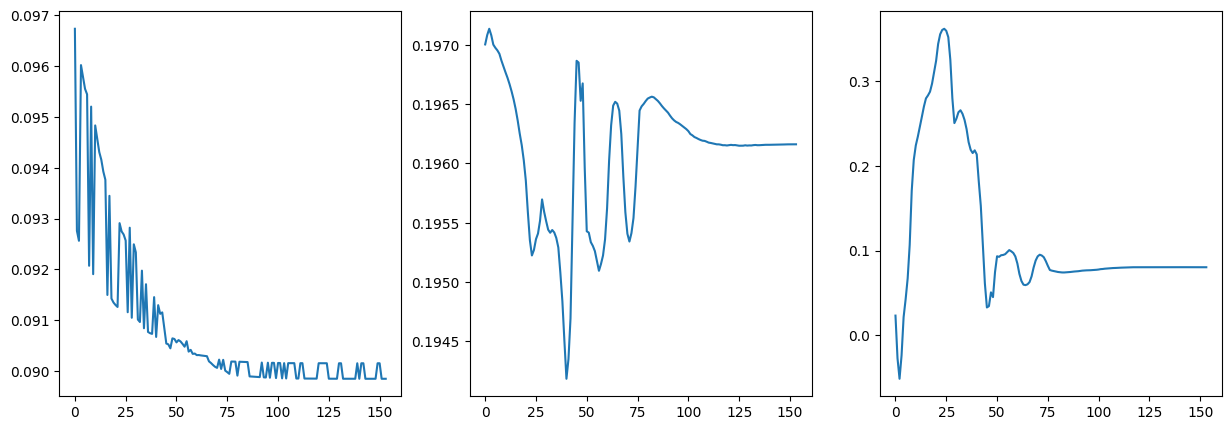

In [32]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot(train_loss)
axes[1].plot(val_loss)
axes[2].plot(val_corr)

In [33]:
for seq, diagonal, track in dataloader_val:
    break

In [34]:
diag_init = torch.from_numpy(np.ones((BATCH_SIZE, data.patch_dim - data.start),
                                     dtype=np.float32) * data.patch_dim)

In [37]:
pred = model.contact_map_prediction(track, seq, diag_init)

In [42]:
torch.diag(torch.corrcoef(torch.concatenate([pred,
                                  diagonal[:, data.patch_dim-data.start:]], dim=0))[:32, 32:])

tensor([ 0.3582, -0.0871,  0.0815,  0.0568,  0.1460,  0.1309,  0.2238,  0.3487,
         0.1052,  0.3130,  0.3994,  0.0313,  0.0997,  0.4286, -0.0707,  0.1801,
        -0.0746,  0.2514,  0.0570,  0.1467, -0.0029,  0.2856,  0.3635,  0.0593,
         0.4668,  0.3058,  0.3012,  0.4087,  0.0157,  0.3345,  0.1704,  0.0071])

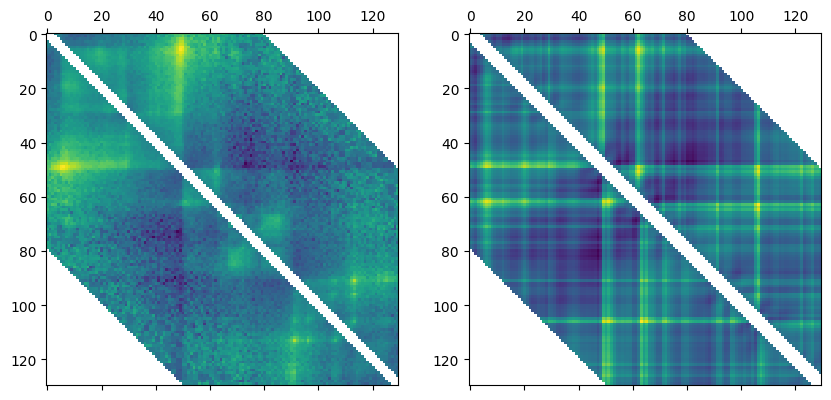

In [47]:
_, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].matshow(util.convert_diags_to_full_contact(diagonal[0].cpu().detach().numpy(), data.start, data.stop))
axes[1].matshow(util.convert_diags_to_full_contact(pred[0].cpu().detach().numpy(), data.start+1, data.stop))